In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from sae_lens import SAE
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
from functools import partial
import string
import bitsandbytes
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from scipy.stats import trim_mean
from torch.utils.data import DataLoader, Dataset
import gc
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

In [2]:
# import sys
# sys.path.append("../src/")
# from get_reasoning_feats import get_ds_saes 

In [3]:
from huggingface_hub import login
login(token="REDACTED")

In [4]:
# torch.cuda.empty_cache()   
# gc.collect()

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)

In [6]:
device = utils.get_device()
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.36s/it]


In [7]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
release = "llama_scope_r1_distill"
sae_id = "l25r_400m_slimpajama_400m_openr1_math"
sae, cfg_dict, sparsity = SAE.from_pretrained_with_cfg_and_sparsity(release, sae_id)
sae = sae.to(device)

In [10]:
def format_prompt_aqua(query, reasoning=True, include_options=True):
    COT_PROMPT = r'Please reason step by step, and put your final answer within \boxed{}.'
    question, options = query['question'], query['options']
    joined_options = "\n".join(options) if include_options else ""
    if reasoning:
        return f'<s>[INST] {question}{joined_options}\n{COT_PROMPT} [/INST] \n<think>\n'
    else:
        return f'<s>[INST] {question}{joined_options}\n [/INST] \n'

In [11]:
def format_prompt_tqa(question, reasoning=True):
    COT_PROMPT = r'Please reason step by step, and put your final answer within \boxed{}.'
    if reasoning:
        return f'<s>[INST] {question}\n{COT_PROMPT} [/INST] \n<think>\n'
    else:
        return f'<s>[INST] {question}\n [/INST] \n'  

In [12]:
class TokenizedPromptDataset(Dataset):
    def __init__(self, tokenized_inputs, queries):
        self.input_ids = tokenized_inputs['input_ids']
        self.attn_masks = tokenized_inputs['attention_mask']
        self.queries = queries

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'query': self.queries[idx]
        }

In [13]:
def collate_tokenized(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    queries = [item['query'] for item in batch]
    return {'input_ids': input_ids, 'attention_mask': attention_mask}, queries

In [14]:
def get_cot_batch(ds, batch_size, tokenizer, model, collate_fn):
    
    tokenized = tokenizer(
        [format_prompt_aqua(q, reasoning=False, include_options=False) for q in ds],
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=8192
    )

    dataset = TokenizedPromptDataset(tokenized, ds)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    all_preds = []
    all_generations = []
    all_questions = []
    MCQ_ANSWER_PROMPT = 'The correct answer is ('
    
    for batch_inputs, queries in tqdm(dataloader):
        
        input_ids = batch_inputs['input_ids'].to(model.device)
        attention_mask = batch_inputs['attention_mask'].to(model.device)

        with torch.inference_mode():
            output_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=512,
                do_sample=True,
                temperature=0.6,
                top_p=0.95,
                pad_token_id=tokenizer.eos_token_id
            )
    
        decoded = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
        decoded = ["".join(out.split('[/INST]')[1:]) for out in decoded]
        all_generations.extend(decoded)
    
        answer_prompts = [text + MCQ_ANSWER_PROMPT for text in decoded]
        answer_inputs = tokenizer(answer_prompts, return_tensors='pt', padding=True, truncation=True).to(model.device)
    
        with torch.inference_mode():
            out = model(**answer_inputs)
    
        for i, query in enumerate(queries):
            options = query['options']
            letters = list(string.ascii_uppercase)[:len(options)]
            valid_ids = tokenizer.convert_tokens_to_ids(letters)
            logits = out.logits[i, -1, valid_ids]
            pred_idx = torch.argmax(logits).item()
            all_preds.append(letters[pred_idx])
            all_questions.append(query['question'])

    return all_questions, all_preds, all_generations
    

In [16]:
aqua_ds = load_dataset('aqua_rat', 'raw', split='test')

Generating validation split: 100%|██████████| 254/254 [00:00<00:00, 100962.21 examples/s]


In [26]:
# questions, preds, cots = get_cot_batch(aqua_ds, 16, tokenizer, model, collate_tokenized)

In [27]:
with open('../data/query_list.pkl', 'rb') as f:
    questions = pickle.load(f)

In [29]:
with open('../data/preds_list.pkl', 'rb') as f:
    preds = pickle.load(f)

In [30]:
with open('../data/cot_list.pkl', 'rb') as f:
    cots = pickle.load(f)

In [34]:
with open('../data/query_feats.pkl', 'rb') as f:
    query_feats = pickle.load(f)

In [35]:
with open('../data/cot_feats.pkl', 'rb') as f:
    cot_feats = pickle.load(f)

In [36]:
with open('../data/preds_list.pkl', 'rb') as f:
    preds_feats = pickle.load(f)

In [37]:
query_feats

[24593, 30892, 30022, 27769, 14012, 6688, 3094, 22315, 31076, 4923]

In [40]:
prompts = [format_prompt_aqua(query, reasoning=False, include_options=False) for query in aqua_ds]

In [258]:
q_feat_acts = defaultdict(float)

for feat in query_feats:
    ans = []
    for i in tqdm(range(len(prompts))):
        test_input = tokenizer(
            prompts[i],
            return_tensors='pt'
        ).to(model.device)
        ans.append(get_sae_acts(model, sae, test_input, 25)[0][feat])
    q_feat_acts[feat] = np.mean([i.item() for i in ans])

100%|██████████| 254/254 [00:31<00:00,  7.95it/s]


In [260]:
q_feat_acts

defaultdict(float,
            {24593: 0.13993660623105023,
             30892: 0.07957254278319557,
             30022: 0.4698125548719421,
             27769: 0.33370821969950293,
             14012: 0.5787202235985929,
             6688: 0.4418561369415343,
             3094: 0.32625941615405046,
             22315: 0.5009210414480506,
             31076: 0.3065049894682066,
             4923: 0.2690728832417586})

In [38]:
def get_sae_acts(model, sae, input_batch, layer, agg='mean'):

    activation_dict = {}

    def hook_fn(module, input, output):
        activation_dict["hidden"] = output

    hook = model.model.layers[layer].register_forward_hook(hook_fn)

    model.eval()

    with torch.no_grad():
        _ = model(**input_batch)

    hook.remove()

    hidden_states = activation_dict['hidden']
    raw_feats = sae.encode(hidden_states)

    if agg == 'mean':
        result= raw_feats.mean(dim=1)
    elif agg == 'last':
        result = raw_feats[:, -1]
    elif agg == 'none':
        result = raw_feats

    del hidden_states, raw_feats

    return result

In [41]:
test_input = tokenizer(
            prompts[7],
            return_tensors='pt'
        ).to(model.device)
result = get_sae_acts(model, sae, test_input, 25, agg='none')

In [42]:
tokenizer.convert_ids_to_tokens(test_input['input_ids'][0])

['<｜begin▁of▁sentence｜>',
 '<s',
 '>[',
 'INST',
 ']',
 'ĠA',
 'Ġtrain',
 'Ġrunning',
 'Ġat',
 'Ġa',
 'Ġspeed',
 'Ġof',
 'Ġ',
 '100',
 'Ġmiles',
 '/h',
 'our',
 ',',
 'Ġtakes',
 'Ġ',
 '10',
 'Ġhours',
 'Ġto',
 'Ġreach',
 'Ġits',
 'Ġdestination',
 '.',
 'ĠAfter',
 'Ġcovering',
 'Ġquarter',
 'Ġof',
 'Ġthe',
 'Ġdistance',
 ',',
 'Ġit',
 'Ġstarts',
 'Ġraining',
 'Ġand',
 'Ġthe',
 'Ġtrain',
 'Ġhas',
 'Ġto',
 'Ġbe',
 'Ġslowed',
 'Ġto',
 'Ġspeed',
 'Ġof',
 'Ġ',
 '75',
 'Ġmiles',
 '/h',
 'our',
 '.',
 'ĠWhat',
 'Ġis',
 'Ġthe',
 'Ġtotal',
 'Ġjourney',
 'Ġduration',
 '?Ċ',
 'Ġ[/',
 'INST',
 ']',
 'ĠĊ']

In [43]:
for feat in [14012, 22315]:
    print(result[0][:,feat])

tensor([0.0000, 2.8564, 5.3388, 3.4417, 4.5819, 5.2501, 1.5725, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.6891, 3.1992,
        1.7240], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [44]:
result[0][:, 14012]

tensor([0.0000, 2.8564, 5.3388, 3.4417, 4.5819, 5.2501, 1.5725, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.6891, 3.1992,
        1.7240], device='cuda:0', grad_fn=<SelectBackward0>)

In [45]:
def bin_token_activations(activation_tensor, num_bins=20):
    """
    activation_tensor: 1D tensor of shape [seq_len]
    Returns a binned activation tensor of shape [num_bins]
    """
    seq_len = activation_tensor.shape[0]
    bin_indices = torch.linspace(0, num_bins, steps=seq_len, dtype=torch.long)
    bin_indices = torch.clamp(bin_indices, max=num_bins - 1)

    # Initialize bins
    binned = torch.zeros(num_bins)
    counts = torch.zeros(num_bins)

    for i, activation in enumerate(activation_tensor):
        idx = bin_indices[i].item()
        binned[idx] += activation
        counts[idx] += 1

    # Avoid divide-by-zero
    counts = torch.clamp(counts, min=1)
    return binned / counts

In [51]:
def get_binned_token_acts(prompts, feature):
    
    tensor_list = []

    for i in tqdm(range(len(prompts))): 
        inputs = tokenizer(
                prompts[i],
                return_tensors='pt'
            ).to(model.device)
        result = get_sae_acts(model, sae, inputs, 25, agg='none')
        feature_acts = result[0][:, feature]
        binned_acts = bin_token_activations(feature_acts.to('cpu'))
        tensor_list.append(binned_acts)

    return torch.stack(tensor_list)
    

In [77]:
query_feats

[24593, 30892, 30022, 27769, 14012, 6688, 3094, 22315, 31076, 4923]

In [92]:
result = get_binned_token_acts(prompts, 4923)

100%|██████████| 254/254 [00:28<00:00,  8.77it/s]


Text(0.5, 1.0, 'Mean Activation of Feature 22315 by Query Location')

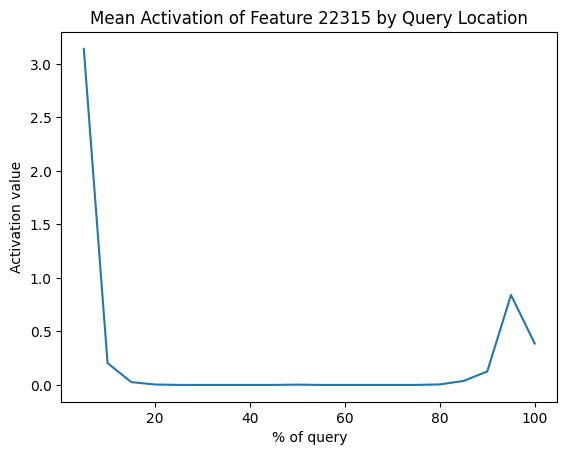

In [93]:
x = np.linspace(5, 100, 20)
y = result.mean(axis=0).detach()
plt.plot(x, y)
plt.ylabel("Activation value")
plt.xlabel("% of query")
plt.title("Mean Activation of Feature 22315 by Query Location")
# plt.savefig("query_22315.png", dpi=300);

In [46]:
bin_token_activations(result[0][:, 14012].to('cpu'))

tensor([2.9092, 3.8015, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.9030], grad_fn=<DivBackward0>)

In [ ]:
# Example usage
num_bins = 20
feature_binned_list = []

for acts in activations_per_prompt:  # acts: 1D tensor for one prompt
    binned = bin_token_activations(acts, num_bins=num_bins)
    feature_binned_list.append(binned.unsqueeze(0))  # Shape: [1, num_bins]

# Stack and average across prompts
all_binned = torch.cat(feature_binned_list, dim=0)  # Shape: [num_prompts, num_bins]
avg_binned = all_binned.mean(dim=0)
